In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = torch.device("cuda")
import torch.nn as nn
import torch.nn.functional as F

class FCModule(nn.Module):
    def __init__(self, num_feature):
        super(FCModule,self).__init__()

        self.fc_layer = nn.Sequential(
            nn.Linear(num_feature*8*7*7,1000),
            nn.ReLU(),
            nn.Linear(1000,10) 
        ) 
    
    def forward(self, input_):
        return self.fc_layer(input_)
    
class CNN(nn.Module):
    def __init__(self,num_feature=32):
        super(CNN,self).__init__()
        self.num_feature=num_feature
        self.layer = nn.Sequential(
            nn.Conv2d(1,self.num_feature,3,1,1),
            nn.BatchNorm2d(self.num_feature),
            nn.ReLU(),
            nn.Conv2d(self.num_feature,self.num_feature*2,3,1,1),
            nn.BatchNorm2d(self.num_feature*2),
            nn.ReLU(),
            nn.AvgPool2d(2,2),
            
            nn.Conv2d(self.num_feature*2,self.num_feature*4,3,1,1),
            nn.BatchNorm2d(self.num_feature*4),
            nn.ReLU(),
            nn.AvgPool2d(2,2),
            
            nn.Conv2d(self.num_feature*4,self.num_feature*8,3,1,1),
            nn.BatchNorm2d(self.num_feature*8),
            nn.ReLU(),
        )
        self.fc_layer = FCModule(num_feature)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                # Kaming Initialization
                nn.init.kaiming_normal_(m.weight.data)
                m.bias.data.fill_(0)        
        
    def forward(self,x):
        out = self.layer(x)
        out = out.view(x.size()[0],-1)
        out = self.fc_layer(out)
        return F.log_softmax(out, dim=1)

model = CNN().to(device)

"""
from torchvision.models.vgg import vgg11
model = vgg11(pretrained=True).to(device)
"""

for n, m in model._modules.items():
    print("Name : " , n, "\n", m)

Name :  layer 
 Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU()
  (10): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (11): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): ReLU()
)
Name :  fc_layer 
 FCModule(
  (fc_layer): Sequential(
    (0): Linear(in_features=12544, out_features=1000, bias=True)
    (1): ReLU()
    (2): Linear(in_featu

In [3]:
import torchvision
from torchvision import transforms, datasets
import random
def one_sided_padding(x):
    rand1 = random.randrange(0,15,3)
    rand2 = random.randrange(0,15,3)

    zero = np.zeros(shape=[28,28,1])
    zero[rand1:rand1+12,rand2:rand2+12,:]=np.asarray(x).reshape(12,12,1)
    return zero

loss_func = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

mnist_train =  datasets.MNIST("./", train=True, 
                         transform=transforms.Compose([
                            transforms.RandomCrop(22),
                            transforms.Resize(12),
                            transforms.Lambda(one_sided_padding),
                            transforms.ToTensor(),
                         ]), 
                         target_transform=None, 
                         download=True)
train_loader = torch.utils.data.DataLoader(mnist_train,batch_size=128, shuffle=True, num_workers=2, drop_last=True)

test_loader = torch.utils.data.DataLoader(
                     datasets.MNIST('./mnist_data', download=True, train=False, transform=transforms.Compose([
                           transforms.RandomCrop(22),
                           transforms.Resize(12),
                           transforms.Lambda(one_sided_padding),
                           transforms.ToTensor(),
                       ])),
                      batch_size=1, shuffle=True)

In [4]:
for i in range(10000):
    model.train()
    for j,[image,label] in enumerate(train_loader):
        x = image.to(device, dtype=torch.float)
        y_= label.to(device)
        
        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output,y_)
        loss.backward()
        optimizer.step()
        
         
    cnt = 0
    
    model.eval()
    with torch.no_grad():
        for image,label in test_loader:
            x = image.to(device, dtype=torch.float)
            y_= label.to(device)

            output = model.forward(x)

            values,idx = output.max(dim=1)
            cnt += torch.sum(y_==idx).float().cpu().data

        acc = cnt / len(test_loader.dataset)

        print("Test Data Accuracy: {}%".format(100*acc))
        if acc > 0.97:
            break

Test Data Accuracy: 85.93000030517578%
Test Data Accuracy: 94.12999725341797%
Test Data Accuracy: 97.3699951171875%


In [5]:
from GradCam import GradCam
grad_cam = GradCam(model=model, feature_layer=("layer", "13"), device=device)

In [6]:
from GradCam import GuidedBackpropReLUModel
gb_model = GuidedBackpropReLUModel(model=model, device=device)
gb_model

layer Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): <built-in method apply of FunctionMeta object at 0x6fca0508>
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): <built-in method apply of FunctionMeta object at 0x6fca0508>
  (6): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): <built-in method apply of FunctionMeta object at 0x6fca0508>
  (10): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (11): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): <built-in method 

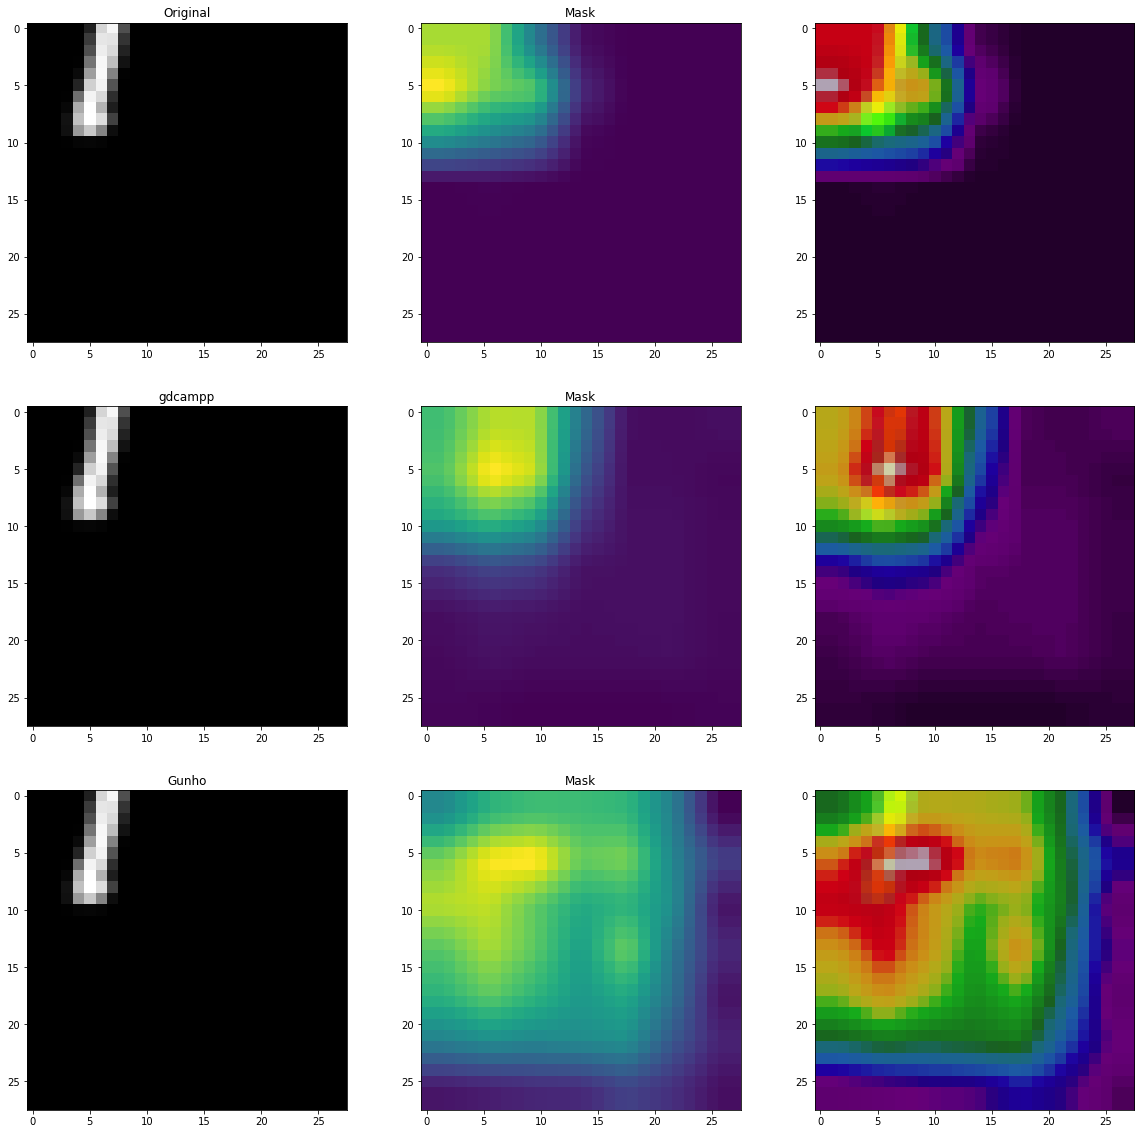

In [7]:
import cv2
for i, (input_, label_) in enumerate(test_loader):
    input_ = input_.to(device, dtype=torch.float)
    label_ = label_.to(device)
    input_.requires_grad_(True)
    target_index = None
    
    ### Grad Cam Original Paper Algorithm ###
    img = input_[0].permute(1,2,0).cpu().detach().numpy()
    cam_mask = grad_cam(input_, target_index, mode="gdcam")

    plt.figure(figsize=(20, 20))
    plt.title("File : %s"%("Temp"))
    ax = plt.subplot(331)
    ax.set_title("Original"); plt.imshow(img[:, :, 0], cmap="gray")
    ax = plt.subplot(332)
    ax.set_title("Mask"); plt.imshow(cam_mask)
    GradCam.plotting_cam_on_image(img, cam_mask, plt, subplot=333)    
    #########################################
    
    ### Grad Cam ++ Algorithm ###
    img = input_[0].permute(1,2,0).cpu().detach().numpy()
    cam_mask = grad_cam(input_, target_index, mode="gdcampp")    
    
    ax = plt.subplot(334)
    ax.set_title("gdcampp"); plt.imshow(img[:, :, 0], cmap="gray")
    ax = plt.subplot(335)
    ax.set_title("Mask"); plt.imshow(cam_mask)    
    GradCam.plotting_cam_on_image(img, cam_mask, plt, subplot=336)
    #############################
    
    ### Gunho Algorithm, But Need Fix it ###
    ### Not complete implementation      ###
    cam_mask = grad_cam(input_, target_index, mode="gunho")
    
    img = input_[0].permute(1,2,0).cpu().detach().numpy()
    cam_img = GradCam.cam_on_image(img, cam_mask)  
    
    ax = plt.subplot(337)
    ax.set_title("Gunho"); plt.imshow(img[:, :, 0], cmap="gray")
    ax = plt.subplot(338)
    ax.set_title("Mask"); plt.imshow(cam_mask)    
    GradCam.plotting_cam_on_image(img, cam_mask, plt, subplot=339)
    break

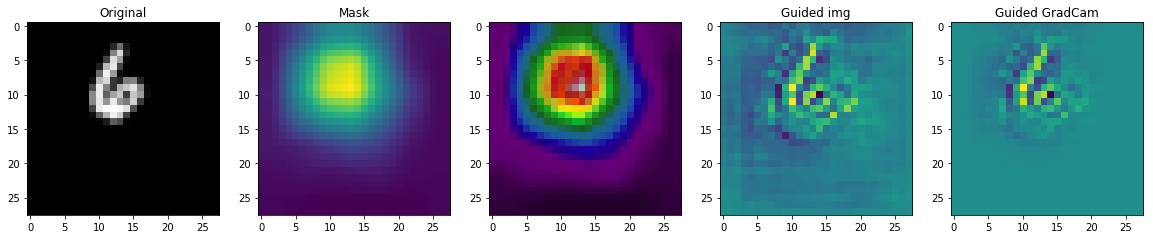

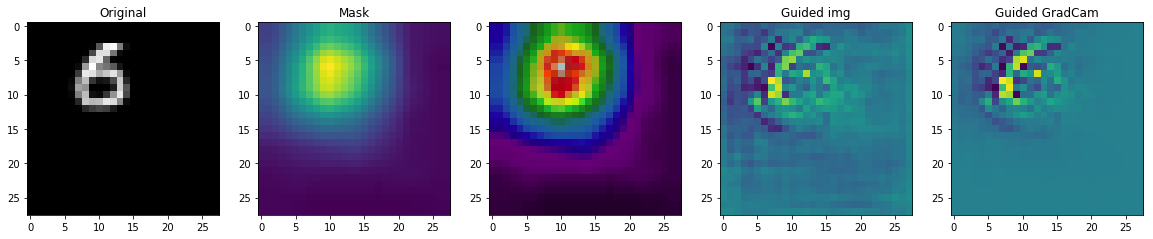

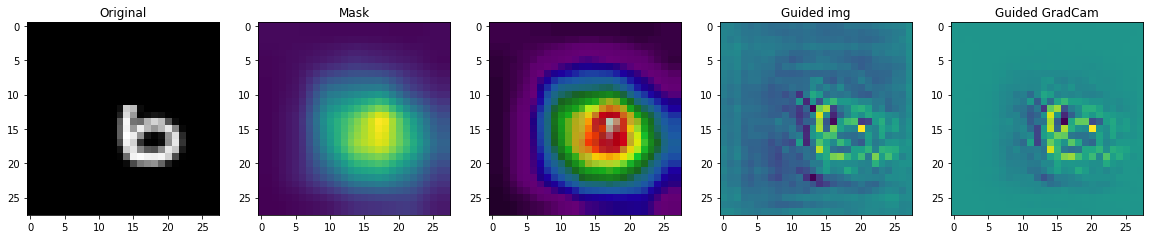

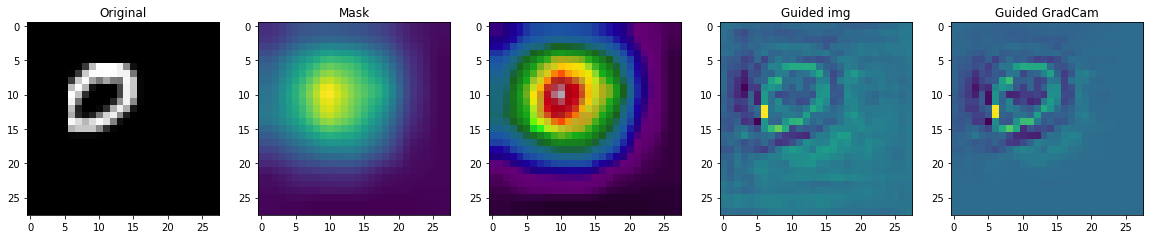

In [8]:
for i, (input_, label_) in enumerate(test_loader):
    input_ = input_.to(device, dtype=torch.float)
    label_ = label_.to(device)
    input_.requires_grad_(True)
    target_index = None
    
    img = input_[0].permute(1,2,0).cpu().detach().numpy()
    cam_mask = grad_cam(input_, target_index, mode="gdcampp")
    
    gb_img = gb_model(input_, index=target_index)
    cam_gb = gb_model.gb_on_cam(gb_img)
    
    plt.figure(figsize=(20, 20))
    plt.title("File : %s"%("Temp"))
    ax = plt.subplot(151)
    ax.set_title("Original"); plt.imshow(img[:, :, 0], cmap="gray")
    ax = plt.subplot(152)
    ax.set_title("Mask"); plt.imshow(cam_mask)
    GradCam.plotting_cam_on_image(img, cam_mask, plt, subplot=153)
    ax = plt.subplot(154)
    ax.set_title("Guided img"); plt.imshow(gb_img)
    ax = plt.subplot(155)
    ax.set_title("Guided GradCam"); plt.imshow(cam_gb)
    if i == 3 : break